In [ ]:
# Module to add classifier output to background image (IR intensity)
# Include filtering (erosion) to remove small pixel clusters
# Include contrast enhancement and saturation adjustment
# Replacement for time consuming photoshop editing
# April 2023

In [ ]:
# Link a google drive to the notebook, if required
import os, sys
from google.colab import drive
drive.mount('/content/drive')
#change this based on your setup
root = '/content/drive/MyDrive/Colab/research/'
sys.path.append(root +'code/')
datapath =  root + 'data/'
print('This is the datapath: ', datapath)

Mounted at /content/drive
This is the datapath:  /content/drive/MyDrive/Colab/research/data/


In [ ]:
# These modules work directly with CoLab
import cv2
import numpy
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from osgeo import gdal
import matplotlib.pyplot as plt

In [ ]:
# Define the image inputs. Put the assets in the data directory
# Planet Labs asset
ps = 'area2_0530_2022_8bands.tif'
# Classifier output from COCKTAIL workflow (copied from PCloud)
image ="area2_0530_2022_8bands_19-04-2023-17-53_raster_classified_color_svm.png"

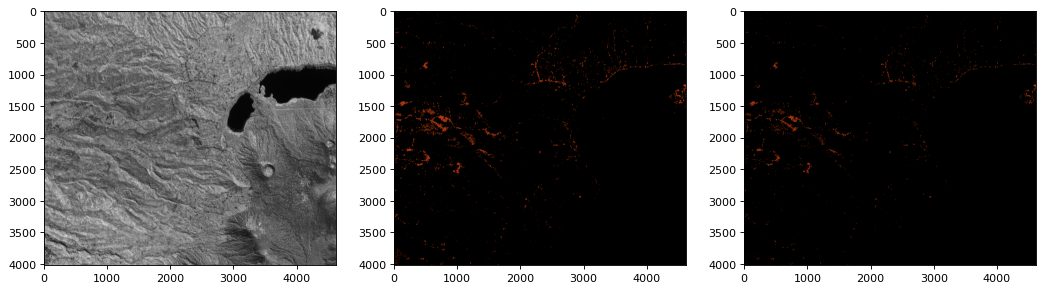

In [ ]:
# Get IR and perform filtering; show results
# https://opensourceoptions.com/blog/gdal-python-tutorial-reading-and-writing-raster-datasets/
# https://developers.planet.com/docs/apis/data/sensors/
# https://here.isnew.info/how-to-save-a-numpy-array-as-a-geotiff-file-using-gdal.html

img_brg = cv2.imread(datapath + image)
img = cv2.cvtColor(img_brg, cv2.COLOR_BGR2RGB)
#name = 'agroforestry_latest.png'
#name = 'forestry.png'
name = 'settlement_latest.png'

ks = 2     # seems reasonable (also ok: 1, 2, 3)
kernel_1 = numpy.ones((ks, ks), numpy.uint8)
img_eroded = cv2.erode(img, kernel_1)

bands = gdal.Open(datapath + ps)
#NIR on SuperDove: band8; on Dove: band4
#band4 = bands.GetRasterBand(4)

band8 = bands.GetRasterBand(8)
nir = band8.ReadAsArray()

rows = 1
columns = 3
fig = plt.figure(figsize=(16,16), dpi=80)
images = [nir, img, img_eroded]

j = 1
for i in range (0, len(images)):
  fig.add_subplot(rows, columns, j)
  plt.imshow(images[i], cmap = 'gray')
  j = j+1

plt.imsave(datapath + "nir.png", nir, cmap = 'gray')
plt.imsave(datapath + name, img_eroded, cmap = 'gray')

In [ ]:
# Check image dimensions pior to arithmetic operations

background = cv2.imread(datapath + 'nir.png')

#name = 'forestry.png'
#name = 'agroforestry_latest.png'
name = 'settlement_latest.png'
category = cv2.imread(datapath + name)

print(background.shape)
print(category.shape)

(4019, 4618, 3)
(4019, 4618, 3)


True

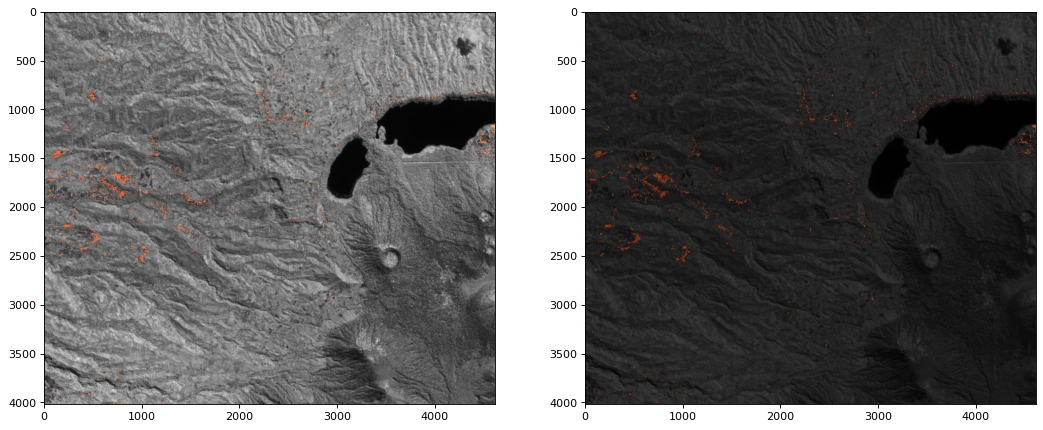

In [ ]:
# V1 - add classification result with NIR
overlay1_brg = cv2.add(background, category)
overlay1 = cv2.cvtColor(overlay1_brg, cv2.COLOR_BGR2RGB)
vnir1 = '+V1nir.png'

# V2 - add classification with NIR, weighted
a = 0.3     # 0.35 ...  factor for the background
b = 1 - a   # resultant factor for the forground (selected category)
c = 0

overlay2_brg = cv2.addWeighted(background, a, category, b, c)
overlay2 = cv2.cvtColor(overlay2_brg, cv2.COLOR_BGR2RGB)
vnir2 = '+V2nir.png'

rows = 1
columns = 2
fig = plt.figure(figsize=(16,16), dpi=80)
images = [overlay1, overlay2]

j = 1
for i in range (0, len(images)):
  fig.add_subplot(rows, columns, j)
  plt.imshow(images[i], cmap = 'gray')
  j = j+1

cv2.imwrite(datapath + (name.split('.png')[0] + vnir1), overlay1)
cv2.imwrite(datapath + (name.split('.png')[0] + vnir2), overlay2)

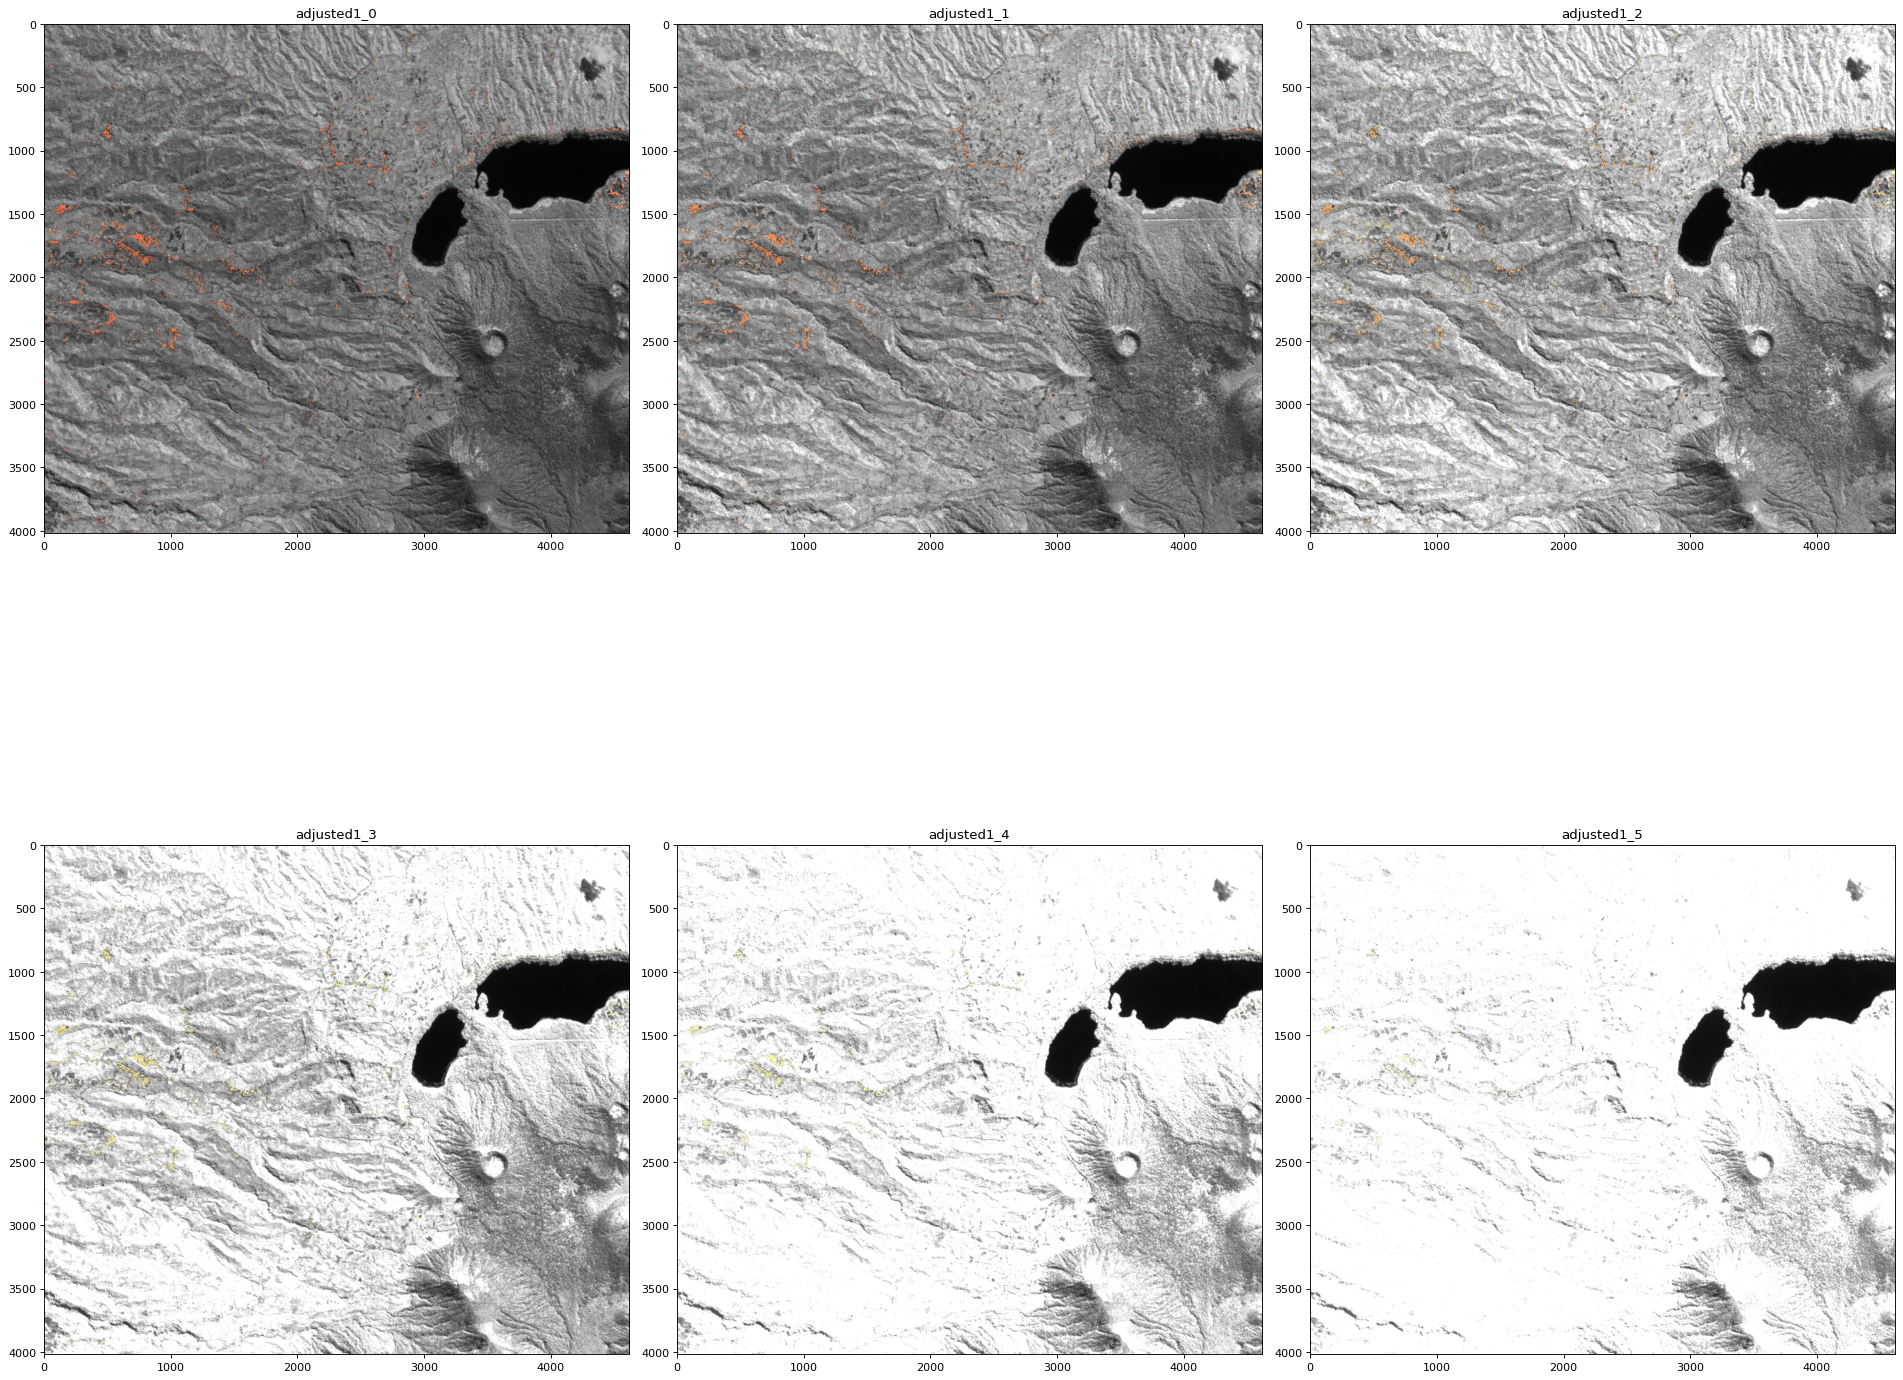

In [ ]:
# Increase contrast across a range of settings
# https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

v1nir = '+V1nir.png'
V1 = name.split('.png')[0] + v1nir
image1_brg = cv2.imread(datapath + V1)
image1 = cv2.cvtColor(image1_brg, cv2.COLOR_BGR2RGB)

v2nir = '+V2nir.png'
V2 = name.split('.png')[0] + v2nir
image2_brg = cv2.imread(datapath + V2)
image2 = cv2.cvtColor(image2_brg, cv2.COLOR_BGR2RGB)

# set a rage for the key parameter to vary
alpha = [1.0, 1.25, 1.5, 2.0, 2.5, 3.0]

adjusted1 = []
adjusted2 = []
for i in range(0, len(alpha)):
  t = cv2.convertScaleAbs(image1, alpha=alpha[i], beta=0)
  adjusted1.append(cv2.cvtColor(t, cv2.COLOR_BGR2RGB))
  v = cv2.convertScaleAbs(image2, alpha=alpha[i], beta=0)
  adjusted2.append(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))

rows = 2
columns = int(len(alpha) / rows)
fig = plt.figure(figsize=(24,24), dpi=80)

j = 1
for i in range (0, len(adjusted1)):
  fig.add_subplot(rows, columns, j)
  fig.tight_layout()
  plt.title("adjusted1_" + str(i))
  plt.imshow(adjusted1[i], cmap = 'gray')
  j = j+1


In [ ]:
#pick the best one
choice = adjusted1[0]
plt.imsave(datapath + "nir1_contrastadjusted.png", choice, cmap = 'gray')

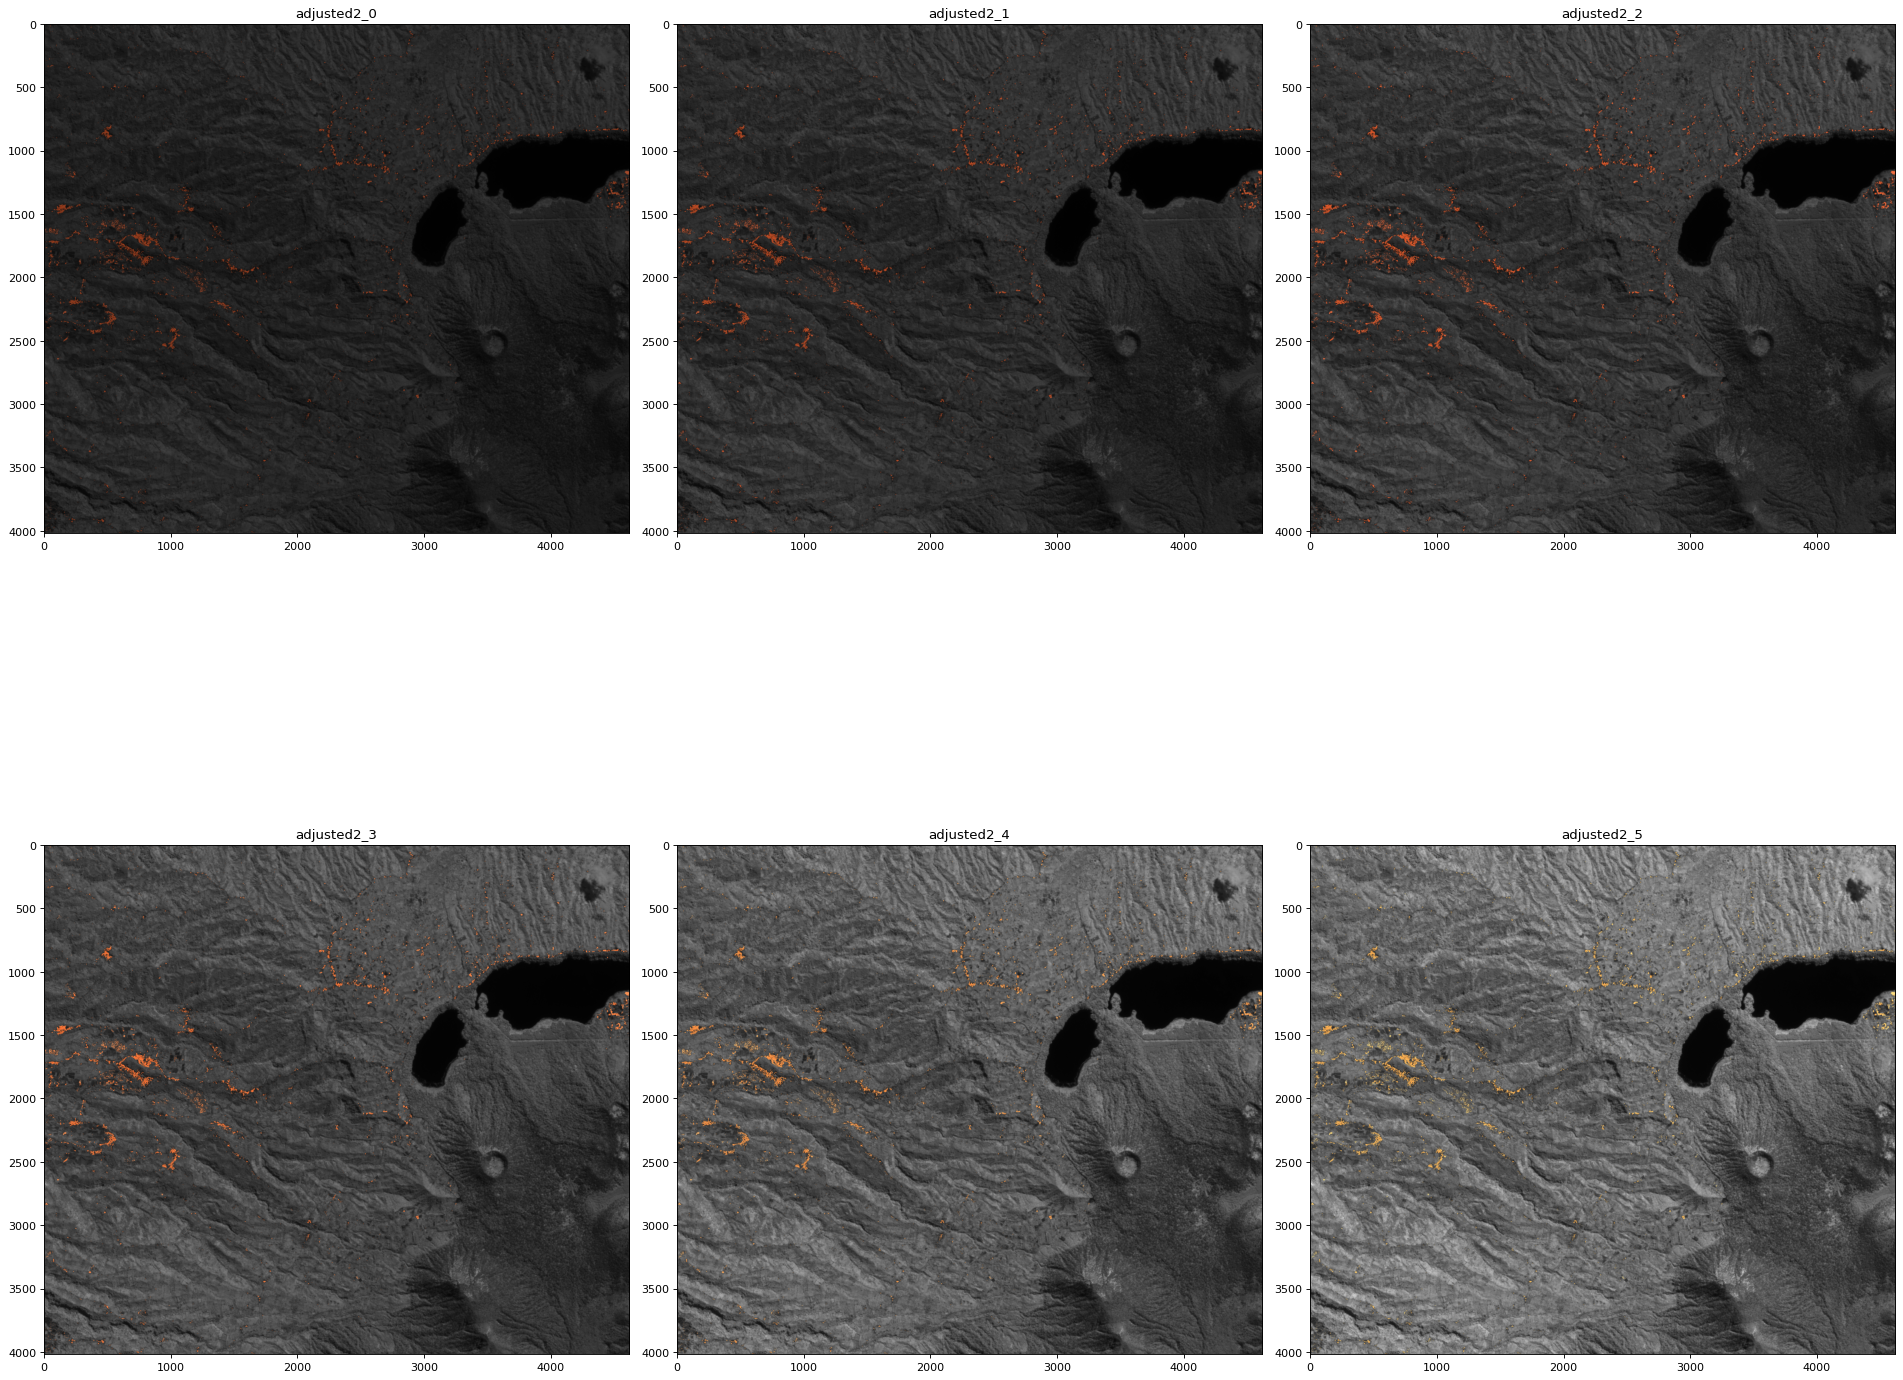

In [ ]:
#same process for the second image set
rows = 2
columns = int(len(alpha) / rows)
fig = plt.figure(figsize=(24,24), dpi=80)
                 
j = 1
for i in range (0, len(adjusted2)):
  fig.add_subplot(rows, columns, j)
  fig.tight_layout()
  plt.title("adjusted2_" + str(i))
  plt.imshow(adjusted2[i], cmap = 'gray')
  j = j+1


In [ ]:
# Pick the best one
choice = adjusted2[3]
plt.imsave(datapath + "nir2_contrastadjusted.png", choice, cmap = 'gray')

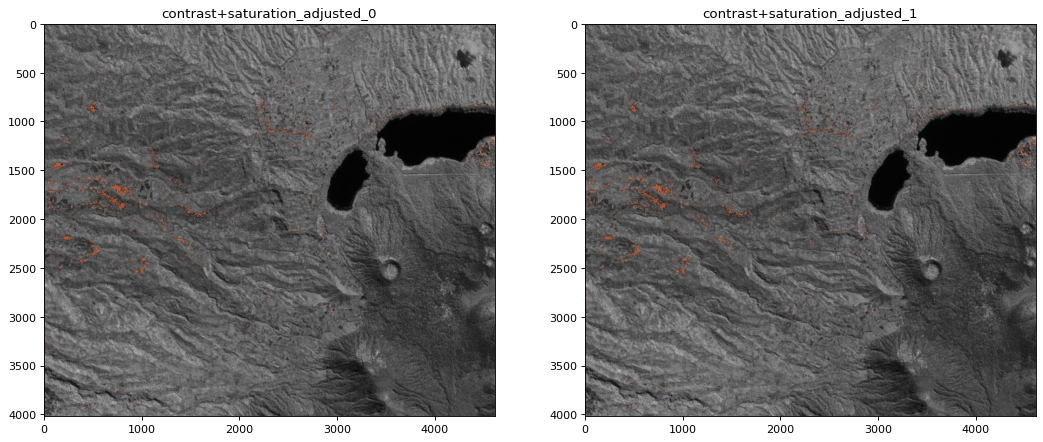

In [ ]:
# Adjust saturation and the previous best solutions - transfer frm opencv defaul BRG to HSV space and then to RGB

nir1 = "nir1_contrastadjusted.png"
nimage1 = cv2.imread(datapath + nir1)

nir2 = "nir2_contrastadjusted.png"
nimage2 = cv2.imread(datapath + nir2)

# Increase saturation ; multiple by a factor to change the saturation
# Multiple by a factor of less than 1 to reduce the brightness 
sf1 = 1.0
bf1 = 0.8

sf2 = 1.2
bf2 = 0.7

# Transform BRG to HSV
hsv1 = cv2.cvtColor(nimage1,cv2.COLOR_BGR2HSV)
# first entry (1) is saturation; second one (2) is brightness
hsv1[...,1] = hsv1[...,1]*sf1
hsv1[...,2] = hsv1[...,2]*bf1
simage1=cv2.cvtColor(hsv1,cv2.COLOR_HSV2RGB)

hsv2 = cv2.cvtColor(nimage2,cv2.COLOR_BGR2HSV)
hsv2[...,1] = hsv2[...,1]*sf2
hsv2[...,2] = hsv2[...,2]*bf2
simage2=cv2.cvtColor(hsv1,cv2.COLOR_HSV2RGB)

rows = 1
columns = 2
fig = plt.figure(figsize=(16,16), dpi=80)
images = [simage1, simage2]

j = 1
for i in range (0, len(images)):
  fig.add_subplot(rows, columns, j)
  plt.title("contrast+saturation_adjusted_" + str(i))
  plt.imshow(images[i], cmap = 'gray')
  j = j+1

plt.imsave(datapath + "nir1_contrastadjusted_sat.png", simage1, cmap = 'gray')
plt.imsave(datapath + "nir2_contrastadjusted_sat.png", simage2, cmap = 'gray')

In [ ]:
# Save the final choice
finalchoice = images[1]
plt.imsave(datapath + "nir_contrastadjusted_sat.png", finalchoice, cmap = 'gray')